# Develop and test pcp bc

test the bias correction procedure on a small subset of the data

ToDo: clean up and add to git repo

In [1]:
import time
import xarray as xr
import dask
import numpy as np
from random import randrange
import gc
import sys
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as patches

# sys.path.append('/glade/u/home/bkruyt/libraries')
# sys.path.append('/glade/u/home/bkruyt/libraries/st_lines')
# sys.path
import quantile_mapping # from same folder.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as patches


### Functions

In [3]:
test=True
def get_livneh(icar_1file):
    """get livneh data, cropped to the icar grid (defined by icar_1file)"""

    t0 = time.time()
    print("\n- - - - - - - - - -   opening livneh files - - - - - - - - - - - - ")

    ### Livneh Precipitation [mm]
    files = glob.glob("/glade/campaign/ral/hap/common/Livneh_met_updated/precip/livneh_unsplit_precip.2021-05-02.19[5-9]*.nc")
    files.extend(glob.glob("/glade/campaign/ral/hap/common/Livneh_met_updated/precip/livneh_unsplit_precip.2021-05-02.20*.nc"))
    files.sort()
    if test:
        livneh = xr.open_mfdataset(files[:10])  # speed up for testing
        print('   ! TEST : ',len(files[:10]), " Livneh precipiation files(years)" ) # the number of files (years)
    else:
        print('   ',len(files), " Livneh precipiation files(years)" ) # the number of files (years)
        livneh = xr.open_mfdataset(files, parallel=True)

    # # # crop livneh to ICAR bounds:
    # buff=10.5
    max_lat=icar_1file.lat.max().values#+buff
    min_lat=icar_1file.lat.min().values#-buff
    max_lon=icar_1file.lon.max().values#+buff
    min_lon=icar_1file.lon.min().values#-buff

    LatIndexer, LonIndexer = 'lat', 'lon'

    livneh = livneh.sel(**{LatIndexer: slice(min_lat, max_lat ),
                            LonIndexer: slice(min_lon, max_lon)})

    # print(livneh)

    livneh_pr   = livneh["PRCP"]#.load()

    # clean up some data; correct time dimension:
    if 'Time' in livneh_pr.dims:
        livneh_pr = livneh_pr.rename( {'Time':'time'})
    if not ('time' in livneh_pr.dims):
        print(' warning ' )

    print("   ", time.time() - t0)
    return livneh_pr #, livneh_tmin, livneh_tmax

In [4]:
noise_path  = "/glade/derecho/scratch/bkruyt/CMIP6"
NOISE_u     = xr.open_dataset(f"{noise_path}/uniform_noise_480_480.nc" )
noise_val   = 0.01


def add_noise(df, noise_val=noise_val, random=True):
    """Add uniform noise to a 2D dataset df."""

    with dask.config.set(**{'array.slicing.split_large_chunks': True}):

        u_noise = NOISE_u.uniform_noise  #.load() # 55000 x 480 x480

        # Add noise to (daily) input data:
        # to avoid taking the same noise values every time, we add a random int.
        t = len(df.time)
        if random:
            r = randrange(1000)
        else:
            r = 0
        noise_arr = noise_val * u_noise[r:(r+t) , :df.shape[1], :df.shape[2] ]
        df = xr.where( df>0, df + noise_val, noise_arr.values)

        return df


### Test

In [5]:
###########
CMIP="CMIP6"
model="MIROC-ES2L"
scen_load ="hist"
base_in  = f"/glade/derecho/scratch/bkruyt/{CMIP}/WUS_icar_LivGrd2"


#### Get input data

In [6]:
start_year=1950 ; end_year=1950 ; dt="3hr"

files=[]
for y in range(int(start_year), int(end_year)+1) :

    if CMIP=="CMIP6":
        files.extend( glob.glob(f'{base_in}/{model}_hist/{dt}/icar_*_{y}*.nc') )
        files.extend( glob.glob(f'{base_in}/{model}_{scen_load}_2004/{dt}/icar_*_{y}*.nc') )
        files.extend( glob.glob(f'{base_in}/{model}_{scen_load}_2049/{dt}/icar_*_{y}*.nc') )

pr   =  xr.open_mfdataset( files )['precip_dt']

#### Get Ref data

In [37]:
start_year=1951 ; end_year=1952 ; dt="3hr"

files=[]
for y in range(int(start_year), int(end_year)+1) :

    if CMIP=="CMIP6":
        files.extend( glob.glob(f'{base_in}/{model}_hist/{dt}/icar_*_{y}*.nc') )
        files.extend( glob.glob(f'{base_in}/{model}_{scen_load}_2004/{dt}/icar_*_{y}*.nc') )
        files.extend( glob.glob(f'{base_in}/{model}_{scen_load}_2049/{dt}/icar_*_{y}*.nc') )

Ref_3h   =  xr.open_mfdataset( files )['precip_dt']

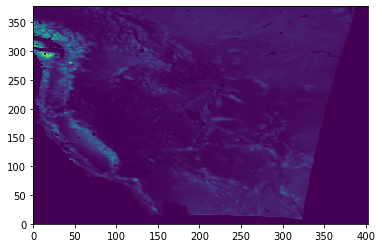

In [32]:
# plt.pcolormesh( pr.sum(dim='time') )

#### Get  Obs data

In [7]:

livneh_pr = get_livneh(icar_1file=pr.isel(time=0))
dsObs     = livneh_pr.load()



- - - - - - - - - -   opening livneh files - - - - - - - - - - - - 
   ! TEST :  10  Livneh precipiation files(years)
    2.670647382736206


In [38]:
## make daily from input and ref:
tdelta_int=3
if tdelta_int<24:
    print("   making daily precip")
    daily = pr.resample(time='1D').sum(dim='time').load()
    dsRef = Ref_3h.resample(time='1D').sum(dim='time').load()
else:
    daily = pr.load()

   making daily precip


In [39]:
## add noise
daily_n = add_noise(daily, noise_val=noise_val, random=True)
dsRef_n = add_noise(dsRef, noise_val=noise_val, random=True)

(365, 50, 50) (731, 50, 50) (3652, 50, 50)


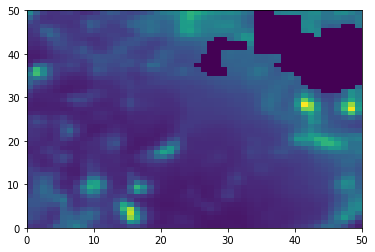

In [198]:
# reduce array shape:
a=150; b=200
daily_n = daily_n.isel(lat=slice(a,b)).isel(lon=slice(a,b))
dsRef_n = dsRef_n.isel(lat=slice(a,b)).isel(lon=slice(a,b))
dsObs   = dsObs.isel(lat=slice(a,b)).isel(lon=slice(a,b))


daily = daily.isel(lat=slice(a,b)).isel(lon=slice(a,b))
pr    = pr.isel(lat=slice(a,b)).isel(lon=slice(a,b))

print( daily_n.shape, dsRef_n.shape, dsObs.shape )
plt.pcolormesh( pr.sum(dim='time') )

In [199]:
np.count_nonzero( daily.values<0)

0

## Bias Correct

NB: (very small) negative values are introduced by the bc procedure when setting extrapolate='1to1'. (This does not happen when dsRef=None. ). To prevent this we set extrapolate to max.


In [200]:
print(daily_n.shape, dsRef_n.shape, dsObs.shape)

bc_daily = quantile_mapping.quantile_mapping_by_group(
    # def quantile_mapping_by_group(input_data, ref_data, data_to_match, (ref should exclude 5y input)
    daily_n,  dsRef_n, dsObs, 
    # daily_n,  None, dsObs, 
    grouper='time.month', detrend=False,  use_ref_data=True,# use_ref_data is not used! set ref_data=None to exclude ref data!
    extrapolate="1to1", n_endpoints=50
    )

print(f"\n   {np.count_nonzero(daily<0)} negative values before BC")
print(f"   {np.nanmin(daily)} min value before BC")
print(f"   {np.count_nonzero(bc_daily<0)} negative values after BC")
print(f"   {np.nanmin(bc_daily)} min value after BC")

(365, 50, 50) (731, 50, 50) (3652, 50, 50)
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate

### Reapply to daily:

In [201]:
correction = bc_daily.values / daily_n.values
# Create a mask for elements where daily sum is zero and bc_daily is positive
# mask = (daily2.values == 0) & (bc_daily.values > 0)
mask = np.logical_and( (daily.values == 0) , (bc_daily.values > 0) )

daily_crtd = daily * correction

daily_corr_final =  np.where( mask, bc_daily, daily_crtd )
# daily_corr_final =  daily_crtd.where( ~mask, bc_daily)  # equivalent xr.where statement


In [202]:
np.count_nonzero(bc_daily<0)
# np.count_nonzero(daily2<0)
# np.count_nonzero(correction<0)
np.count_nonzero(daily_crtd.values<0)
np.count_nonzero(daily_corr_final<0)

0

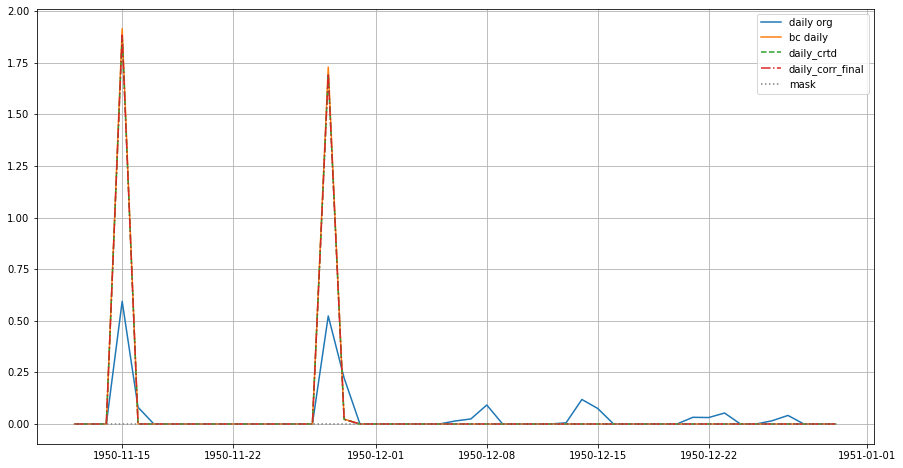

In [203]:
# t0=-50 ; t1=-1 ; y=200; x=200
t0=-50 ; t1=-1 ; y=20; x=20   # when cropped
plt.figure(figsize=(15,8))

plt.plot(daily.time[t0:t1], daily[t0:t1,y,x], label='daily org')
plt.plot(bc_daily.time[t0:t1], bc_daily[t0:t1,y,x], label='bc daily')
plt.plot(daily_crtd.time[t0:t1], daily_crtd[t0:t1,y,x], label='daily_crtd', linestyle="--")
plt.plot(daily_crtd.time[t0:t1], daily_corr_final[t0:t1,y,x], label='daily_corr_final', linestyle="-.")

plt.plot(bc_daily.time[t0:t1], mask[t0:t1,y,x]*10, label='mask', color='grey', linestyle=":")

# plt.plot(bc_daily.time[t0:t1], correction[t0:t1,y,x], label='correction', color='red', linestyle=":")

# plt.ylim(0,.2) # zoom in to see the effect of np.where( mask, bc_daily, daily_crtd )

plt.legend()
# plt.xlim(bc_daily.time.isel(time=0), bc_daily.time.isel(time=80))
plt.grid()

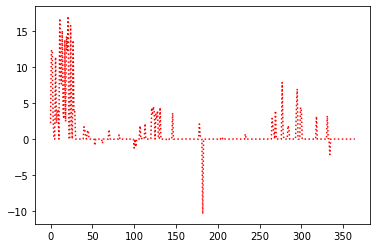

In [204]:

# plt.plot(bc_daily.time[t0:t1], mask[t0:t1,y,x]*10, label='mask', color='grey', linestyle=":")

# plt.plot(bc_daily.time[t0:t1], correction[t0:t1,y,x], label='correction', color='red', linestyle=":")

plt.plot( correction[:,y,x], label='correction', color='red', linestyle=":")

### Reapply to 3hr:

In [66]:
print("      pr.shape:",pr.shape)
print("      pr == 0 :",np.sum(pr.values==0))
print("   applying correction to ",tdelta_int,"-hourly data")

      pr.shape: (2920, 378, 403)
      pr == 0 : 289478208
   applying correction to  3 -hourly data


In [67]:
correction = np.where(bc_daily.values>=0, bc_daily.values / daily_n.values, 0 ) # 
print(f"      correction min/max:{np.nanmin(correction)} {np.nanmax(correction)} ") 

      correction min/max:-926812.75 20740.25390625 


In [68]:
# Calculate the correction array
correction = bc_daily.values / daily_n.values
# repeat for nr of timesteps per day:
correction =  np.repeat(correction, (24 / tdelta_int), axis=0)

# Create a mask for elements where daily sum is zero and bc_daily is positive
mask = (daily.values == 0) & (bc_daily.values > 0)
# mask = np.logical_and( (daily2.values == 0) , (bc_daily.values > 0) )
print( f"condition met :{np.count_nonzero( mask)} times (in daily mask)" )

# mask = mask.interp(time=pr.time)
mask2 = np.repeat(mask, (24 / tdelta_int), axis=0)
print( f"condition met :{np.count_nonzero( mask2)} times (in 3h mask)" )

print(f"      mask shape: {mask.shape}")
print(f"      mask2 shape: {mask2.shape}")
print(f"      correction shape: {correction.shape} ") # \n
print(f"      correction min/max:{np.nanmin(correction)} {np.nanmax(correction)} ") 

condition met :2555266 times (in daily mask)
condition met :20442128 times (in 3h mask)
      mask shape: (365, 378, 403)
      mask2 shape: (2920, 378, 403)
      correction shape: (2920, 378, 403) 
      correction min/max:-926812.75 20740.25390625 


In [69]:
### bc introduces negative values....

In [205]:
print(
    np.count_nonzero( daily.values<0), '\n',
    np.count_nonzero( daily_n.values<0), '\n',
    np.count_nonzero( bc_daily.values<0), '\n',
    np.count_nonzero( correction<0), '\n',
    np.count_nonzero( dsRef_n<0), '\n',
    np.count_nonzero( dsObs<0), '\n',

)

print(np.nanmin(bc_daily), np.nanmin(correction))

0 
 0 
 16089 
 16089 
 0 
 0 

-0.0055648508 -3688.3735


#### interpolate the daily bc to 3hr

1D to test

In [136]:
y=100; x=100
bc_tdelta_1D =  bc_daily[:,y,x].interp(time=pr.time, method='zero') /(24 / tdelta_int) 
# bc_tdelta =  np.repeat(bc_daily.values, (24 / tdelta_int), axis=0) / (24 / tdelta_int)

# bc_tdelta = np.interp(pr.time.values, bc_daily.time.values, bc_daily.values) # to deep?

# print(f"   bc_tdelta shape: {bc_tdelta.shape}")
print( bc_tdelta_1D.time )

<xarray.DataArray 'time' (time: 2920)>
array(['1950-01-01T00:00:00.000000000', '1950-01-01T03:00:00.000000000',
       '1950-01-01T06:00:00.000000000', ..., '1950-12-31T15:00:00.000000000',
       '1950-12-31T18:00:00.000000000', '1950-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lat      float64 35.53
    lon      float64 -118.3
  * time     (time) datetime64[ns] 1950-01-01 ... 1950-12-31T21:00:00


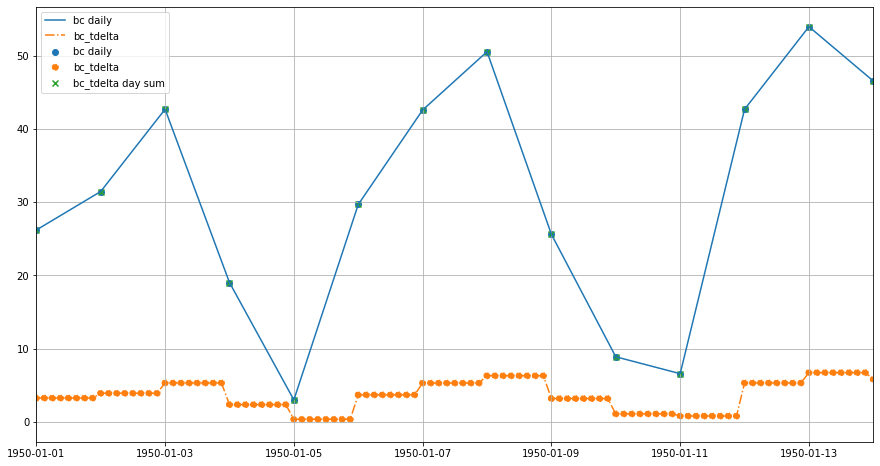

In [161]:

plt.figure(figsize=(15,8))
# plt.plot(bc_daily.time, bc_daily[:,y,x], label='bc daily')
# plt.plot(bc_tdelta.time, bc_tdelta[:,y,x], label='bc_tdelta', linestyle="-.")
plt.plot(bc_daily.time, bc_daily[:,y,x], label='bc daily')
plt.plot(bc_tdelta_1D.time, bc_tdelta_1D, label='bc_tdelta', linestyle="-.")

plt.scatter(bc_daily.time, bc_daily[:,y,x], label='bc daily')
plt.scatter(bc_tdelta_1D.time, bc_tdelta_1D, label='bc_tdelta', linestyle="-.")
plt.scatter(bc_daily.time, bc_tdelta_1D.resample(time='D').sum(), 
            label='bc_tdelta day sum',marker='x')

# plt.plot(bc_tdelta[:t1,y,x], label='bc_tdelta', linestyle=":")
# plt.plot( mask[:,y,x]*10, label='mask', color='grey', linestyle=":")
# plt.plot( mask2[:,y,x]*10, label='mask2', color='black', linestyle=":")
# plt.plot( correction[:,y,x], label='correction', color='red', linestyle=":")
plt.xlim(bc_daily.time[0], bc_daily.time[13])

plt.legend()
# plt.xlim(bc_daily.time.isel(time=0), bc_daily.time.isel(time=80))
plt.grid()

### interp 3D

In [139]:
bc_tdelta =  bc_daily.interp(time=pr.time, method='zero') /(24 / tdelta_int)  # time consuming in 3D!

pr3  = pr.copy()

pr3 *= correction

pr4 = pr3.where(~mask2, bc_tdelta )

# da_pcp = pr.where(~mask, bc_tdelta/(24 / tdelta_int))
# da_pcp = da_pcp.where(~mask, bc_tdelta )

pr5 =  np.where( mask2, bc_tdelta, pr3 )

In [160]:
## NANS:
# np.count_nonzero(pr.isnull()), np.count_nonzero(pr3.isnull()), np.count_nonzero(pr4.isnull())

## neg vals:
np.count_nonzero(pr.values<0), np.count_nonzero(pr3.values<0), np.count_nonzero(pr4.values<0)

(0, 8351, 8351)

In [192]:
# print( np.where( pr3 <0) )
print( np.where( pr3 ==np.nanmin(pr3) ) )

# pr3[480,334,137].values, np.nanmin(pr3)

(array([1392]), array([360]), array([106]))


/glade/work/yifanc/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


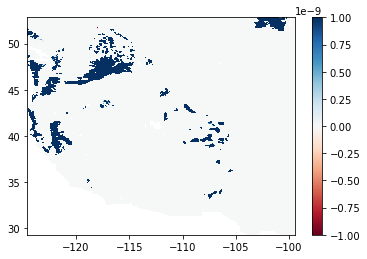

In [189]:

fig,ax0=plt.subplots()
im = ax0.pcolormesh(pr.lon, pr.lat, pr3.isel(time=480),cmap='RdBu' , vmin=-.000000001, vmax=.000000001)
fig.colorbar(im, ax=ax0)

(100.0, 150.0)

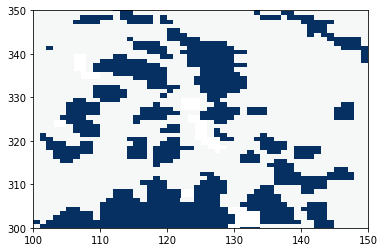

In [186]:
plt.pcolormesh( pr3.isel(time=480),cmap='RdBu' , vmin=np.nanmin(pr3), vmax=-np.nanmin(pr3))
plt.ylim(300,350)
plt.xlim(100,150)

# fig,ax0=plt.subplots()
# im = ax0.pcolormesh(pr.lon, pr.lat, pr3.isel(time=480),cmap='RdBu' , vmin=-.00001, vmax=.00001)
# fig.colorbar(im, ax=ax0)

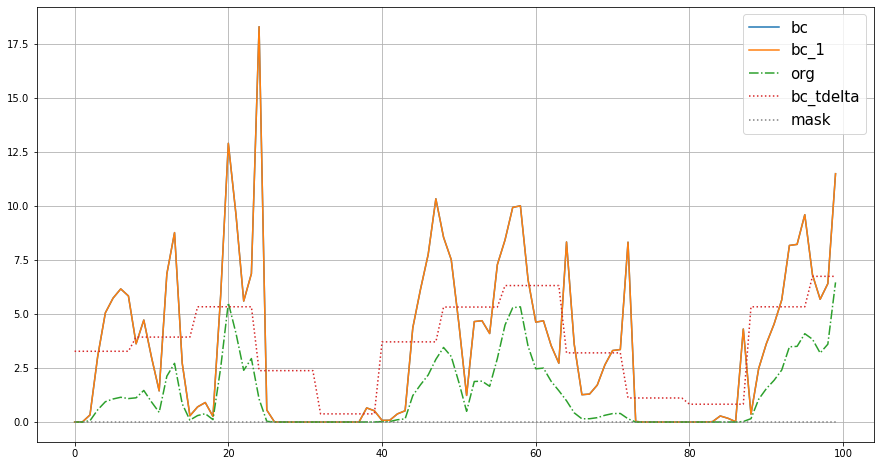

In [159]:

# t1=-1 ; y=31; x=45
t1=100 ; y=100; x=100
plt.figure(figsize=(15,8))
plt.plot(pr4[:t1,y,x], label='bc')
# plt.plot(pr4.time[:t1], pr4[:t1,y,x], label='bc')
plt.plot(pr3[:t1,y,x], label='bc_1')
plt.plot(pr[:t1,y,x], label='org', linestyle="-.")
plt.plot(bc_tdelta[:t1,y,x], label='bc_tdelta', linestyle=":")
plt.plot(mask2[:t1,y,x], label='mask', color='grey', linestyle=":")
plt.grid()
plt.legend(fontsize=15)

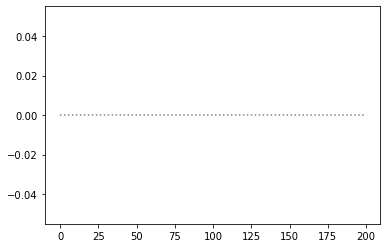

In [97]:
plt.plot(mask[:t1,y,x], label='mask', color='grey', linestyle=":")

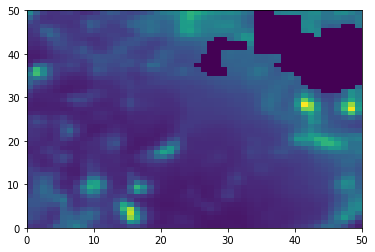

In [53]:
# plt.pcolormesh( pr2.isel(time=-1))
plt.pcolormesh( pr2.sum(dim='time') )

In [34]:
    # # # Apply correction to (all) values
    # pr *= correction

    # for t in range( pr.shape[0]):
    #     # where mask, retrun bc_tdelta (syntax: Returns elements from ‘DataArray’, where ‘cond’ is True, otherwise fill in ‘other’. )
    #     # print(pr[t].shape, mask[t].shape, bc_tdelta[t].shape )
    #     try:
    #         pr[t] = pr[t].where(~mask[t], bc_tdelta[t])
    #     except:
    #         print(f"   pr.shape: {pr.shape} ")
    #         print(f"   mask.shape: {mask.shape} ")
    #         print(f"   bc_tdelta.shape: {bc_tdelta.shape} ")